In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

random.seed(12)

data = pd.read_csv('/content/drive/MyDrive/thesis/Redo/feature selection/overlaping Optimal biomarkers evaluation/data/augmented_cwgan_beta_severity_lfc_1_nosm_fake_neighbor_vectors_all_biomarkers_only.csv')

y_train = data.iloc[:, -1].values
X_train = data.iloc[:, :-1].values

#RF with 5-fold cv evaluation of the cwgan-gp augmented dataset
clf_true = RandomForestClassifier(n_estimators=100 , random_state=42,)

# Cross-validation predictions
y_pred_cv = cross_val_predict(clf_true, X_train, y_train, cv=5)

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred_cv)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Cross-validation accuracy
cv_scores_accuracy = cross_val_score(clf_true, X_train, y_train, cv=5)

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Mean Accuracy:", np.mean(cv_scores_accuracy))
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


Cross-Validation Accuracy Scores: [0.80530973 0.97345133 1.         0.99107143 0.97321429]
Mean Accuracy: 0.9486093552465233
Sensitivity (Recall): 0.9605734767025089
Specificity: 0.9366197183098591


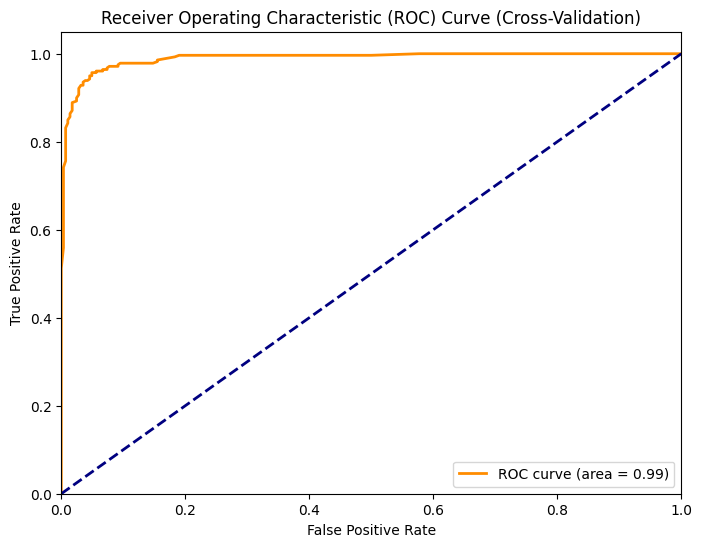

In [3]:
# ROC curve evaluation
y_true_prob_cv_true = cross_val_predict(clf_true, X_train, y_train, cv=5, method='predict_proba')[:, 1]

fpr_cv_true, tpr_cv_true, thresholds_cv_true = roc_curve(y_train, y_true_prob_cv_true)

roc_auc_cv_true = roc_auc_score(y_train, y_true_prob_cv_true)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cv_true, tpr_cv_true, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cv_true))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation)')
plt.legend(loc="lower right")
plt.show()

In [4]:
# Top 5 features
cv_results_true = cross_validate(clf_true, X_train, y_train, cv=5, return_train_score=False, return_estimator=True)

clf_true_fitted = cv_results_true['estimator'][-1]

feature_importances = clf_true_fitted.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': data.columns[:-1], 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_5_features = feature_importance_df.head(5)

print("Top 5 Features:")
print(top_5_features)


Top 5 Features:
    Feature  Importance
26   CCDC65    0.060822
82     HHAT    0.060578
151    RADX    0.047735
159    SCD5    0.042039
166  SH2D1B    0.034577


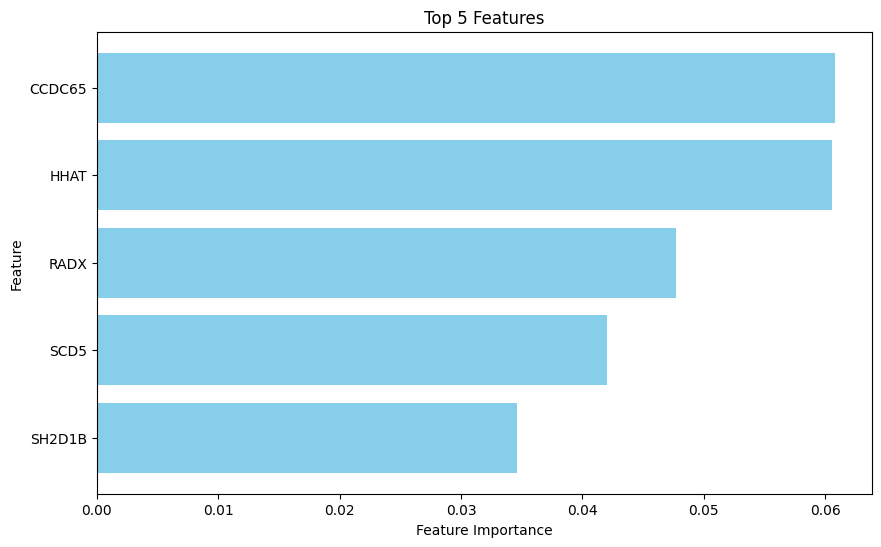

In [5]:
# Plotting the top5 features
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Features')
plt.gca().invert_yaxis()
plt.show()

Top 10 Features:
      Feature  Importance
26     CCDC65    0.060822
82       HHAT    0.060578
151      RADX    0.047735
159      SCD5    0.042039
166    SH2D1B    0.034577
188     TCTN2    0.031892
78     GPR174    0.030699
155      RORA    0.027963
100  KIAA1671    0.027657
175     SPON1    0.027009


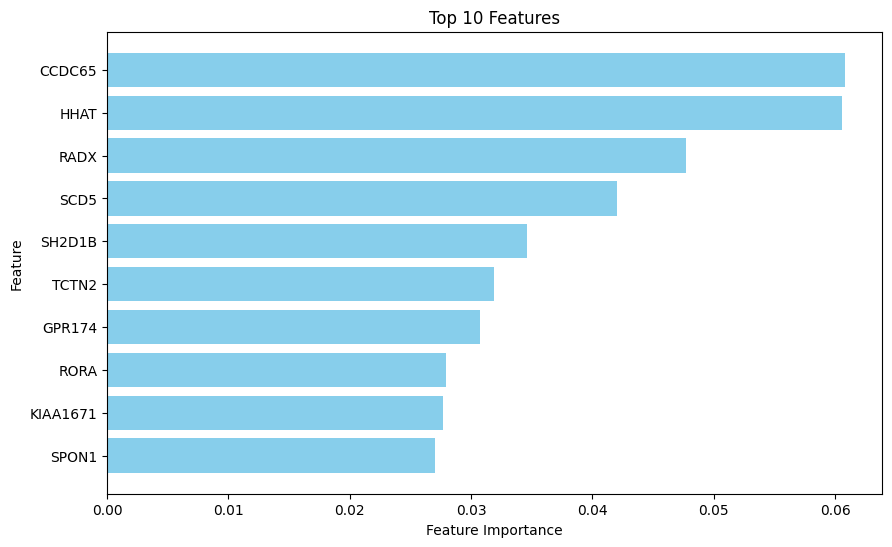

In [6]:
# plotting the  top 10 features

top_10_features = feature_importance_df.head(10)

print("Top 10 Features:")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.gca().invert_yaxis()
plt.show()

In [7]:
# RF using only the top 5 features, evaluation with 5-fold cross validation
clf_top5 = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_top5 = data[top_5_features['Feature']].values


cv_scores_accuracy_top5 = cross_val_score(clf_top5, X_train_top5, y_train, cv=5)

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy_top5)
print("Mean Accuracy:", np.mean(cv_scores_accuracy_top5))



Cross-Validation Accuracy Scores: [0.76106195 0.94690265 0.96460177 0.95535714 0.9375    ]
Mean Accuracy: 0.9130847029077117


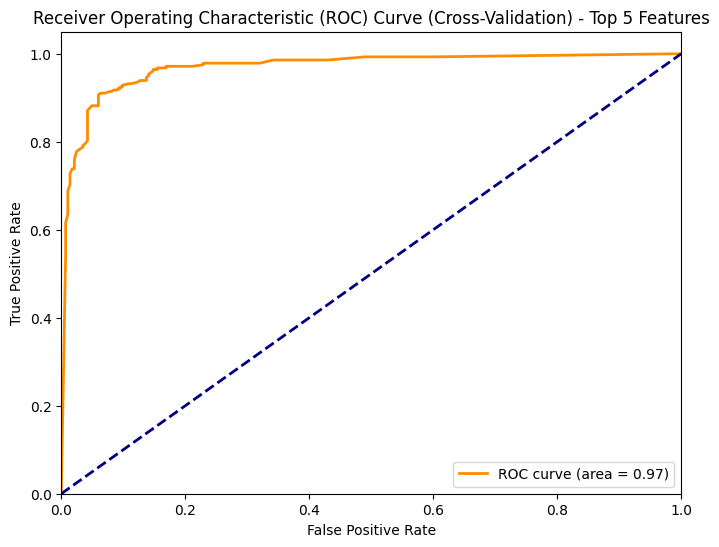

In [8]:
# ROC curve evaluation of the top 5 features
y_true_prob_cv_top5 = cross_val_predict(clf_top5, X_train_top5, y_train, cv=5, method='predict_proba')[:, 1]

fpr_cv_top5, tpr_cv_top5, thresholds_cv_top5 = roc_curve(y_train, y_true_prob_cv_top5)

roc_auc_cv_top5 = roc_auc_score(y_train, y_true_prob_cv_top5)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cv_top5, tpr_cv_top5, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cv_top5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation) - Top 5 Features')
plt.legend(loc="lower right")
plt.show()

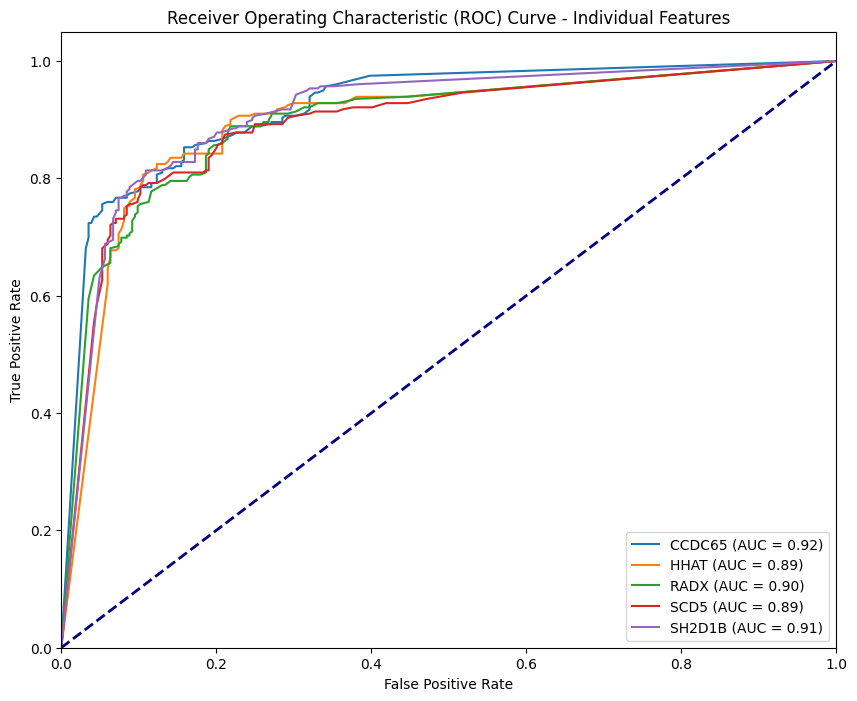

In [9]:
# ROC curve of the top 5 fetaures evaluated individually

plt.figure(figsize=(10, 8))
for i, feature in enumerate(top_5_features['Feature']):
    X_train_single_feature = data[[feature]].values
    y_true_prob_cv_single_feature = cross_val_predict(clf_top5, X_train_single_feature, y_train, cv=5, method='predict_proba')[:, 1]

    fpr_cv_single_feature, tpr_cv_single_feature, _ = roc_curve(y_train, y_true_prob_cv_single_feature)

    auc_value = roc_auc_score(y_train, y_true_prob_cv_single_feature)

    plt.plot(fpr_cv_single_feature, tpr_cv_single_feature, label=f'{feature} (AUC = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Individual Features')

plt.legend(loc="lower right")
plt.show()